In [1]:
# ------------------------
## ----import libraries
# ------------------------
import os,sys
import numpy as np
# xarray
import xarray as xr
# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from matplotlib.colors import Colormap
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cmocean as ccm
import pandas as pd
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox


In [2]:
import multiprocessing.popen_spawn_posix
from distributed import Client

# from dask.distributed import Client
c = Client()
# c = Client(n_workers=6, threads_per_worker=1, memory_limit="8 GiB",local_directory="/gpfsscratch/rech/cli/uor98hu/dask_tmp/")
# import lib_SLXtools_IMHOTEP_2021 as slx
c

<Client: 'tcp://127.0.0.1:42847' processes=5 threads=10, memory=20.97 GB>

In [3]:
CB_colors = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
} 

# load data GAI

## vitesses

In [4]:
%%time
# GAI
# on prend la zone d'interet (en x, y and z) et la période d'intéret

path = "/gpfsstore/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-IMHOTEP.GAI-S/1y/"
chunk_size = {"x":170,"y":300}

imin = 900; imax = 1180
jmin = 940; jmax = 1200
# i_depth = 40 # index pour limiter l'intégral à 500 m de profondeur

# ds_U = xr.open_mfdataset(path +'????/eORCA025.L75-IMHOTEP.GAI_y*.1y_gridU.nc', chunks = chunk_size, parallel=True).chunk({"time_counter":39})\
#                         .sel(time_counter=slice('1993','2015'), depthu=slice(509)).isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))
# ds_V = xr.open_mfdataset(path +'????/eORCA025.L75-IMHOTEP.GAI_y*.1y_gridV.nc', chunks = chunk_size, parallel=True).chunk({"time_counter":39})\
#                         .sel(time_counter=slice('1993','2015'), depthv=slice(509)).isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))

ds_U = xr.open_mfdataset(path +'????/eORCA025.L75-IMHOTEP.GAI_y*.1y_gridU.nc', chunks = chunk_size, parallel=True).chunk({"time_counter":39})\
                        .sel(depthu=slice(509)).isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))
ds_V = xr.open_mfdataset(path +'????/eORCA025.L75-IMHOTEP.GAI_y*.1y_gridV.nc', chunks = chunk_size, parallel=True).chunk({"time_counter":39})\
                        .sel(depthv=slice(509)).isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))

U_vit = ds_U.vozocrtx
V_vit = ds_V.vomecrty
# 
e3u = ds_U.e3u
e3v = ds_V.e3v

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


CPU times: user 952 ms, sys: 74.7 ms, total: 1.03 s
Wall time: 6.42 s


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [5]:
# faire la moyenne pondérée sur la verticale
e3u_factor = (e3u / e3u.sum('depthu'))
e3v_factor = (e3v / e3v.sum('depthv'))

U_vit_wtmean_tm = ((U_vit * e3u_factor).sum('depthu') ).mean('time_counter').compute()
V_vit_wtmean_tm = ((V_vit * e3v_factor).sum('depthv') ).mean('time_counter').compute()

In [6]:
# pour le plot
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
# read grid files
mesh = xr.open_dataset(diri+'mesh_hgr.nc', chunks = chunk_size).squeeze().isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))
tmask = mesh.tmask.isel(nav_lev=0)# grille lat/lon
nav_lon = mesh.nav_lon
nav_lat = mesh.nav_lat

In [7]:
diro = '/gpfsscratch/rech/cli/uor98hu/PLOTS/'

(array([2.4000e+01, 2.0600e+02, 5.8600e+02, 2.1150e+03, 6.3946e+04,
        5.2500e+03, 5.0300e+02, 1.1400e+02, 4.5000e+01, 1.1000e+01]),
 array([-0.3285655 , -0.2569821 , -0.18539867, -0.11381525, -0.04223183,
         0.02935159,  0.10093501,  0.17251843,  0.24410185,  0.31568527,
         0.3872687 ], dtype=float32),
 <BarContainer object of 10 artists>)

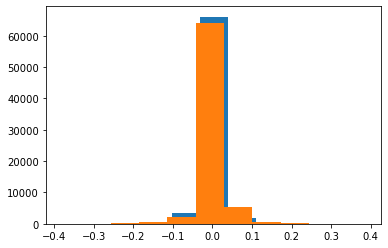

In [15]:
U_vit_wtmean_tm.plot.hist()
V_vit_wtmean_tm.plot.hist()

#### v-component

In [18]:
path = "/gpfsscratch/rech/cli/uor98hu/xtrac_brokenline/"
chunk_size = {"x":170,"y":300}

ds_GAI_section = xr.open_mfdataset(path +'GAI/GAI_1y_*_section_GrEst.nc', chunks = chunk_size, parallel=True).squeeze()

In [19]:
ds_GAI_section

<xarray.Dataset>
Dimensions:                 (time_counter: 39, x: 59, deptht: 75)
Coordinates:
  * deptht                  (deptht) float32 0.5058 1.556 ... 5.902e+03
  * time_counter            (time_counter) datetime64[ns] 1980-07-02 ... 2018...
Dimensions without coordinates: x
Data variables: (12/25)
    nav_lon                 (time_counter, x) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    nav_lat                 (time_counter, x) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    votemper                (time_counter, deptht, x) float32 dask.array<chunksize=(1, 75, 59), meta=np.ndarray>
    vosaline                (time_counter, deptht, x) float32 dask.array<chunksize=(1, 75, 59), meta=np.ndarray>
    vozocrtx_native         (time_counter, deptht, x) float32 dask.array<chunksize=(1, 75, 59), meta=np.ndarray>
    vomecrty_native         (time_counter, deptht, x) float32 dask.array<chunksize=(1, 75, 59), meta=np.ndarray>
    ...                      ...
    Bathymetry              (time_counter, x) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    somxl010                (time_counter, x) float32 dask.array<chunksize=(1, 59), meta=np.ndarray>
    vomevt                  (time_counter, deptht, x) float32 dask.array<chunksize=(1, 75, 59), meta=np.ndarray>
    vomevs                  (time_counter, deptht, x) float32 dask.array<chunksize=(1, 75, 59), meta=np.ndarray>
    vtang                   (time_counter, deptht, x) float32 dask.array<chunksize=(1, 75, 59), meta=np.ndarray>
    vnorm                   (time_counter, deptht, x) float32 dask.array<chunksize=(1, 75, 59), meta=np.ndarray>
Attributes:
    start_date:        19580101
    output_frequency:  1m
    CONFIG:            eORCA025.L75
    CASE:              IMHOTEP.GAI

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


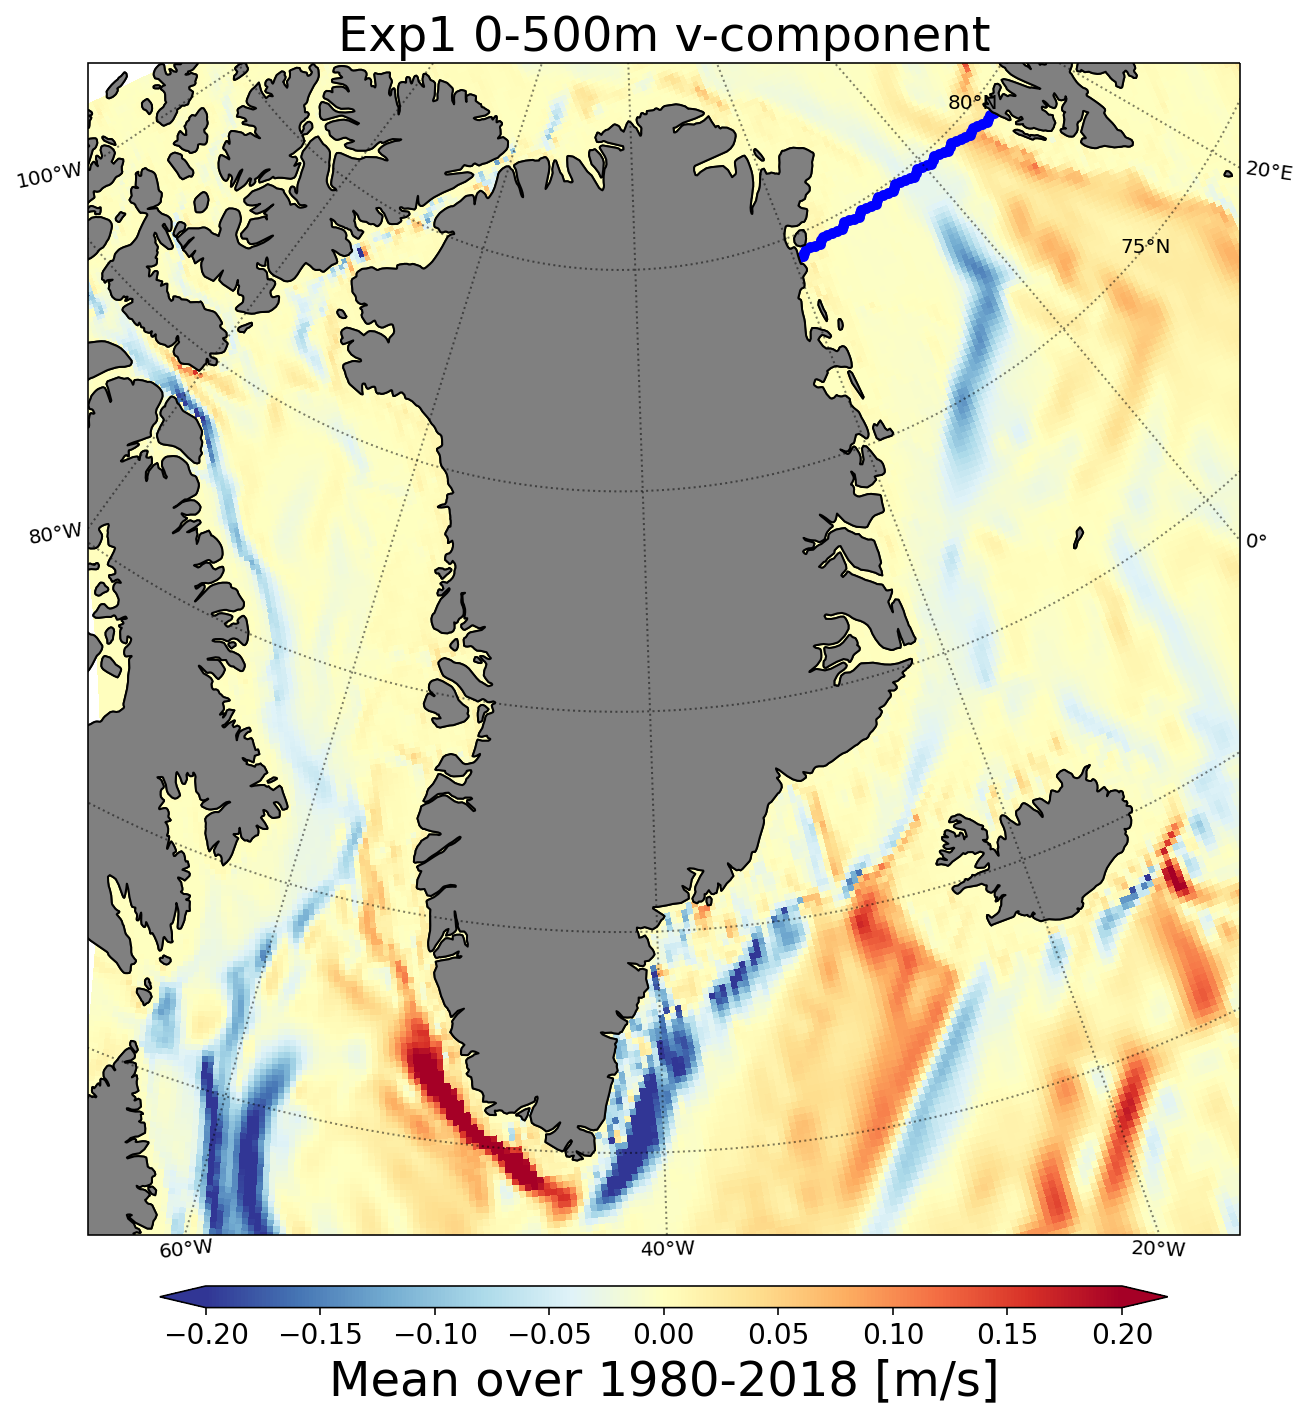

In [21]:
# proj1 = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=70, central_longitude=-42) 
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
# label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

fig, ax_name = plt.subplots(1,1,figsize=(10,15),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
ax_name.set_extent((-65, -15, 58, 84), crs=ccrs.PlateCarree())
ax_name.coastlines()
gl = ax_name.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)#, y_inline=True,)
gl.top_labels = False
# gl.xlabel_style = label_style; gl.ylabel_style = label_style
ax_name.add_feature(land, edgecolor='black')

# --------------------------------------
cs= ax_name.pcolormesh(nav_lon, nav_lat, V_vit_wtmean_tm, shading='flat',cmap =cm.RdYlBu_r, transform=ccrs.PlateCarree(), vmin =-0.2, vmax=0.2)
# ---------------------------------------

cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.01])  #(left, bottom, width, height)

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)

# fig.subplots_adjust(bottom=0.18)

# ---------------------------------------
cbar.set_label(r'Mean over 1980-2018 [m/s]', fontsize=24)
# cbar.set_label(r'Mean over 1993-2015 [m/s]', fontsize=24)
# ---------------------------------------
ax_name.scatter(x=ds_GAI_section.nav_lon[0,:].values,y=ds_GAI_section.nav_lat[0,:].values,s=20,c='b', transform=ccrs.PlateCarree())


ax_name.set_title("Exp1 0-500m v-component", fontsize=24) 

# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 

namo ='GAI_0_500m_mean1980-2018_v.png'
# namo ='GAI_0_500m_mean1993-2015_v.png'


fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


#### u-component

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


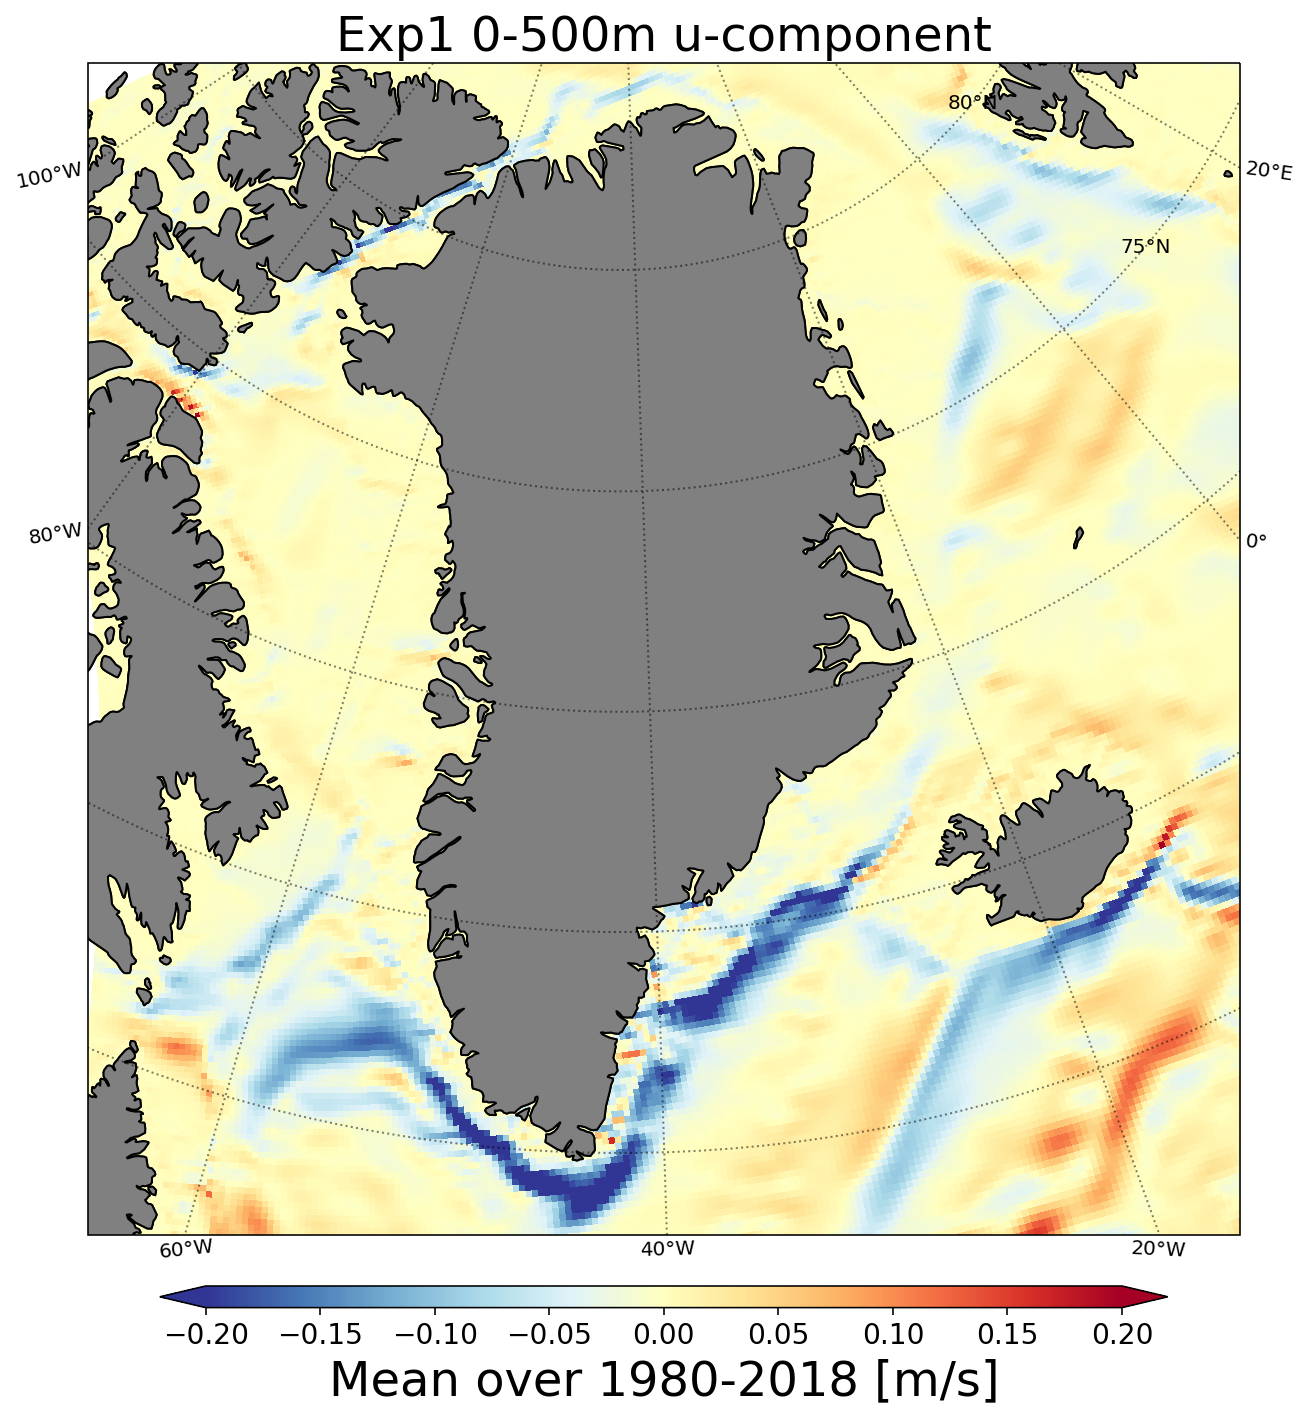

In [11]:
# proj1 = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=70, central_longitude=-42) 
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
# label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

fig, ax_name = plt.subplots(1,1,figsize=(10,15),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
ax_name.set_extent((-65, -15, 58, 84), crs=ccrs.PlateCarree())
ax_name.coastlines()
gl = ax_name.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)#, y_inline=True,)
gl.top_labels = False
# gl.xlabel_style = label_style; gl.ylabel_style = label_style
ax_name.add_feature(land, edgecolor='black')

# --------------------------------------
cs= ax_name.pcolormesh(nav_lon, nav_lat, U_vit_wtmean_tm, shading='flat',cmap =cm.RdYlBu_r, transform=ccrs.PlateCarree(), vmin =-0.2, vmax=0.2)

# ---------------------------------------

cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.01])  #(left, bottom, width, height)

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)

# fig.subplots_adjust(bottom=0.18)

# ---------------------------------------
cbar.set_label('Mean over 1980-2018 [m/s]', fontsize=24)

# cbar.set_label('Mean over 1993-2015 [m/s]', fontsize=24)
# ---------------------------------------


ax_name.set_title("Exp1 0-500m u-component", fontsize=24) 

# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 

# namo ='GAI_0_500m_mean1993-2015_u.png'
namo ='GAI_0_500m_mean1980-2018_u.png'

fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


# sensibility differences

## LOAD DATA

In [8]:
%%time
# AI
# on prend la zone d'interet (en x, y and z) et la période d'intéret

path = "/gpfsstore/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-IMHOTEP.AI-S/1y/"
chunk_size = {"x":170,"y":300}

imin = 900; imax = 1180
jmin = 940; jmax = 1200

ds_U_AI = xr.open_mfdataset(path +'????/eORCA025.L75-IMHOTEP.AI_y*.1y_gridU.nc', chunks = chunk_size, parallel=True).chunk({"time_counter":39})\
                        .sel(depthu=slice(509)).isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))
ds_V_AI = xr.open_mfdataset(path +'????/eORCA025.L75-IMHOTEP.AI_y*.1y_gridV.nc', chunks = chunk_size, parallel=True).chunk({"time_counter":39})\
                        .sel(depthv=slice(509)).isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))

U_vit_AI = ds_U_AI.vozocrtx
V_vit_AI = ds_V_AI.vomecrty
# 
e3u_AI = ds_U_AI.e3u
e3v_AI = ds_V_AI.e3v

# faire la moyenne pondérée sur la verticale
e3u_factor_AI = (e3u_AI / e3u_AI.sum('depthu'))
e3v_factor_AI = (e3v_AI / e3v_AI.sum('depthv'))

U_vit_wtmean_tm_AI = ((U_vit_AI * e3u_factor_AI).sum('depthu') ).mean('time_counter').compute()
V_vit_wtmean_tm_AI = ((V_vit_AI * e3v_factor_AI).sum('depthv') ).mean('time_counter').compute()

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split

CPU times: user 3.34 s, sys: 344 ms, total: 3.68 s
Wall time: 43.4 s


In [9]:
%%time
# S
# on prend la zone d'interet (en x, y and z) et la période d'intéret

path = "/gpfsstore/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-IMHOTEP.S-S/1y/"
chunk_size = {"x":170,"y":300}

imin = 900; imax = 1180
jmin = 940; jmax = 1200

ds_U_S = xr.open_mfdataset(path +'????/eORCA025.L75-IMHOTEP.S_y*.1y_gridU.nc', chunks = chunk_size, parallel=True).chunk({"time_counter":39})\
                        .sel(depthu=slice(509)).isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))
ds_V_S = xr.open_mfdataset(path +'????/eORCA025.L75-IMHOTEP.S_y*.1y_gridV.nc', chunks = chunk_size, parallel=True).chunk({"time_counter":39})\
                        .sel(depthv=slice(509)).isel(x=np.arange(imin,imax),y=np.arange(jmin,jmax))

U_vit_S = ds_U_S.vozocrtx
V_vit_S = ds_V_S.vomecrty
# 
e3u_S = ds_U_S.e3u
e3v_S = ds_V_S.e3v

# faire la moyenne pondérée sur la verticale
e3u_factor_S = (e3u_S / e3u_S.sum('depthu'))
e3v_factor_S = (e3v_S / e3v_S.sum('depthv'))

U_vit_wtmean_tm_S = ((U_vit_S * e3u_factor_S).sum('depthu') ).mean('time_counter').compute()
V_vit_wtmean_tm_S = ((V_vit_S * e3v_factor_S).sum('depthv') ).mean('time_counter').compute()

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split

CPU times: user 3.16 s, sys: 373 ms, total: 3.54 s
Wall time: 43.3 s


In [ ]:
## compute the sensibility differences

In [10]:
V_vit_wtmean_tm_GAI_S = V_vit_wtmean_tm - V_vit_wtmean_tm_S
V_vit_wtmean_tm_GAI_AI = V_vit_wtmean_tm - V_vit_wtmean_tm_AI
V_vit_wtmean_tm_AI_S = V_vit_wtmean_tm_AI - V_vit_wtmean_tm_S

## plot v-component pour les sensibility differences

### sans changer la colorbar

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


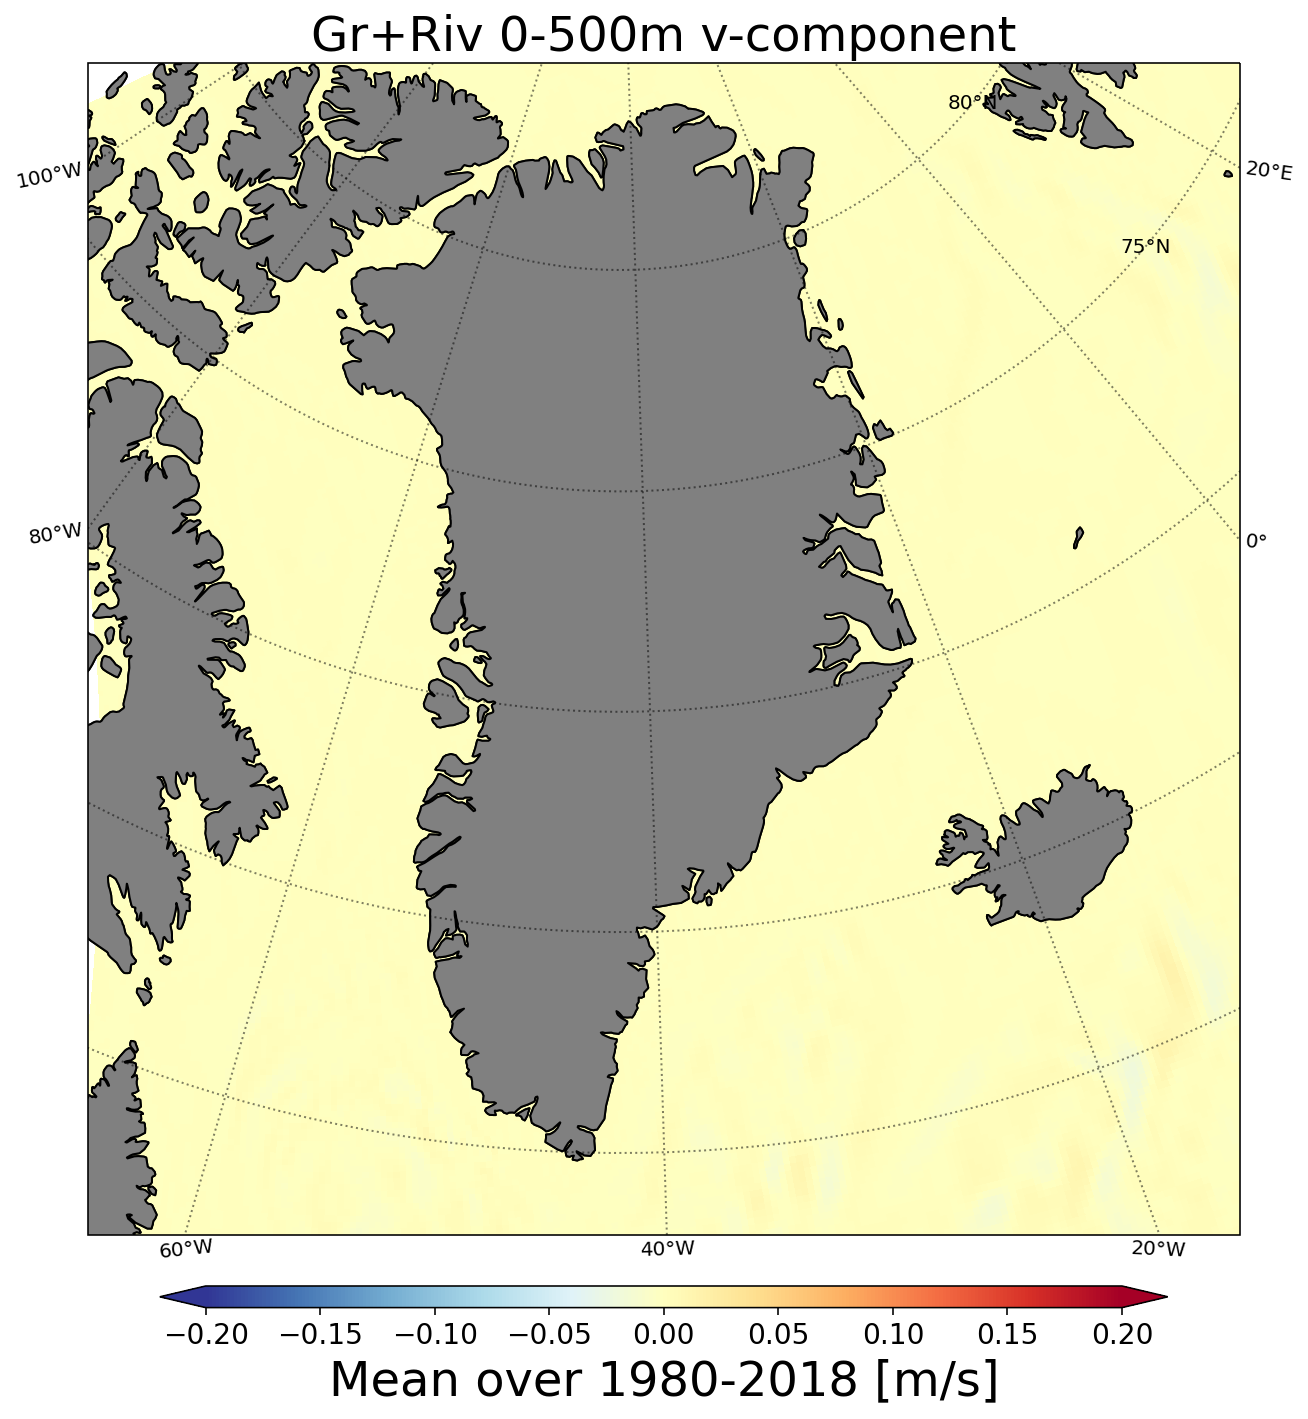

In [11]:
# proj1 = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=70, central_longitude=-42) 
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
# label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

fig, ax_name = plt.subplots(1,1,figsize=(10,15),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
ax_name.set_extent((-65, -15, 58, 84), crs=ccrs.PlateCarree())
ax_name.coastlines()
gl = ax_name.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)#, y_inline=True,)
gl.top_labels = False
# gl.xlabel_style = label_style; gl.ylabel_style = label_style
ax_name.add_feature(land, edgecolor='black')

# --------------------------------------
cs= ax_name.pcolormesh(nav_lon, nav_lat, V_vit_wtmean_tm_GAI_S, shading='flat',cmap =cm.RdYlBu_r, transform=ccrs.PlateCarree(), vmin =-0.2, vmax=0.2)
# ---------------------------------------

cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.01])  #(left, bottom, width, height)

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)

# fig.subplots_adjust(bottom=0.18)

# ---------------------------------------
cbar.set_label(r'Mean over 1980-2018 [m/s]', fontsize=24)
# cbar.set_label(r'Mean over 1993-2015 [m/s]', fontsize=24)
# ---------------------------------------


ax_name.set_title("Gr+Riv 0-500m v-component", fontsize=24) 

# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 

namo ='GAI_S_0_500m_mean1980-2018_v.png'
# namo ='GAI_0_500m_mean1993-2015_v.png'


fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


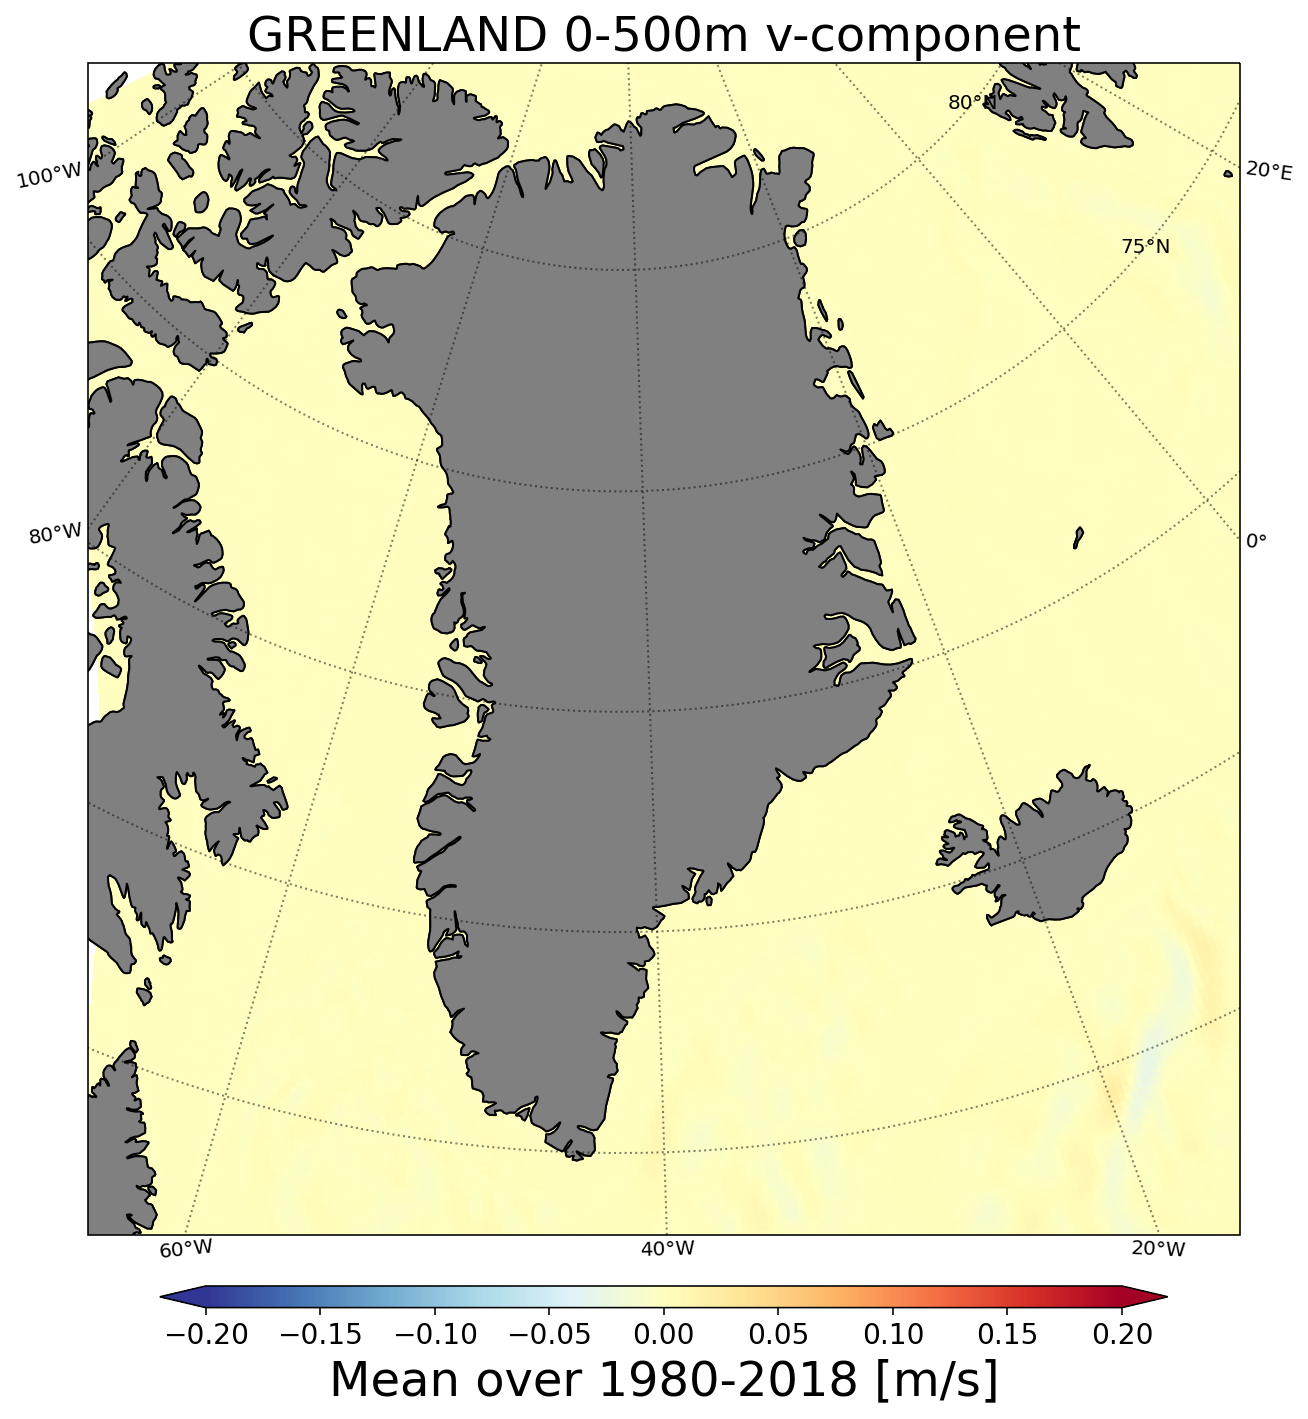

In [12]:
# proj1 = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=70, central_longitude=-42) 
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
# label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

fig, ax_name = plt.subplots(1,1,figsize=(10,15),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
ax_name.set_extent((-65, -15, 58, 84), crs=ccrs.PlateCarree())
ax_name.coastlines()
gl = ax_name.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)#, y_inline=True,)
gl.top_labels = False
# gl.xlabel_style = label_style; gl.ylabel_style = label_style
ax_name.add_feature(land, edgecolor='black')

# --------------------------------------
cs= ax_name.pcolormesh(nav_lon, nav_lat, V_vit_wtmean_tm_GAI_AI, shading='flat',cmap =cm.RdYlBu_r, transform=ccrs.PlateCarree(), vmin =-0.2, vmax=0.2)
# ---------------------------------------

cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.01])  #(left, bottom, width, height)

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)

# fig.subplots_adjust(bottom=0.18)

# ---------------------------------------
cbar.set_label(r'Mean over 1980-2018 [m/s]', fontsize=24)
# cbar.set_label(r'Mean over 1993-2015 [m/s]', fontsize=24)
# ---------------------------------------


ax_name.set_title("GREENLAND 0-500m v-component", fontsize=24) 

# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 

namo ='GAI_AI_0_500m_mean1980-2018_v.png'
# namo ='GAI_0_500m_mean1993-2015_v.png'


fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


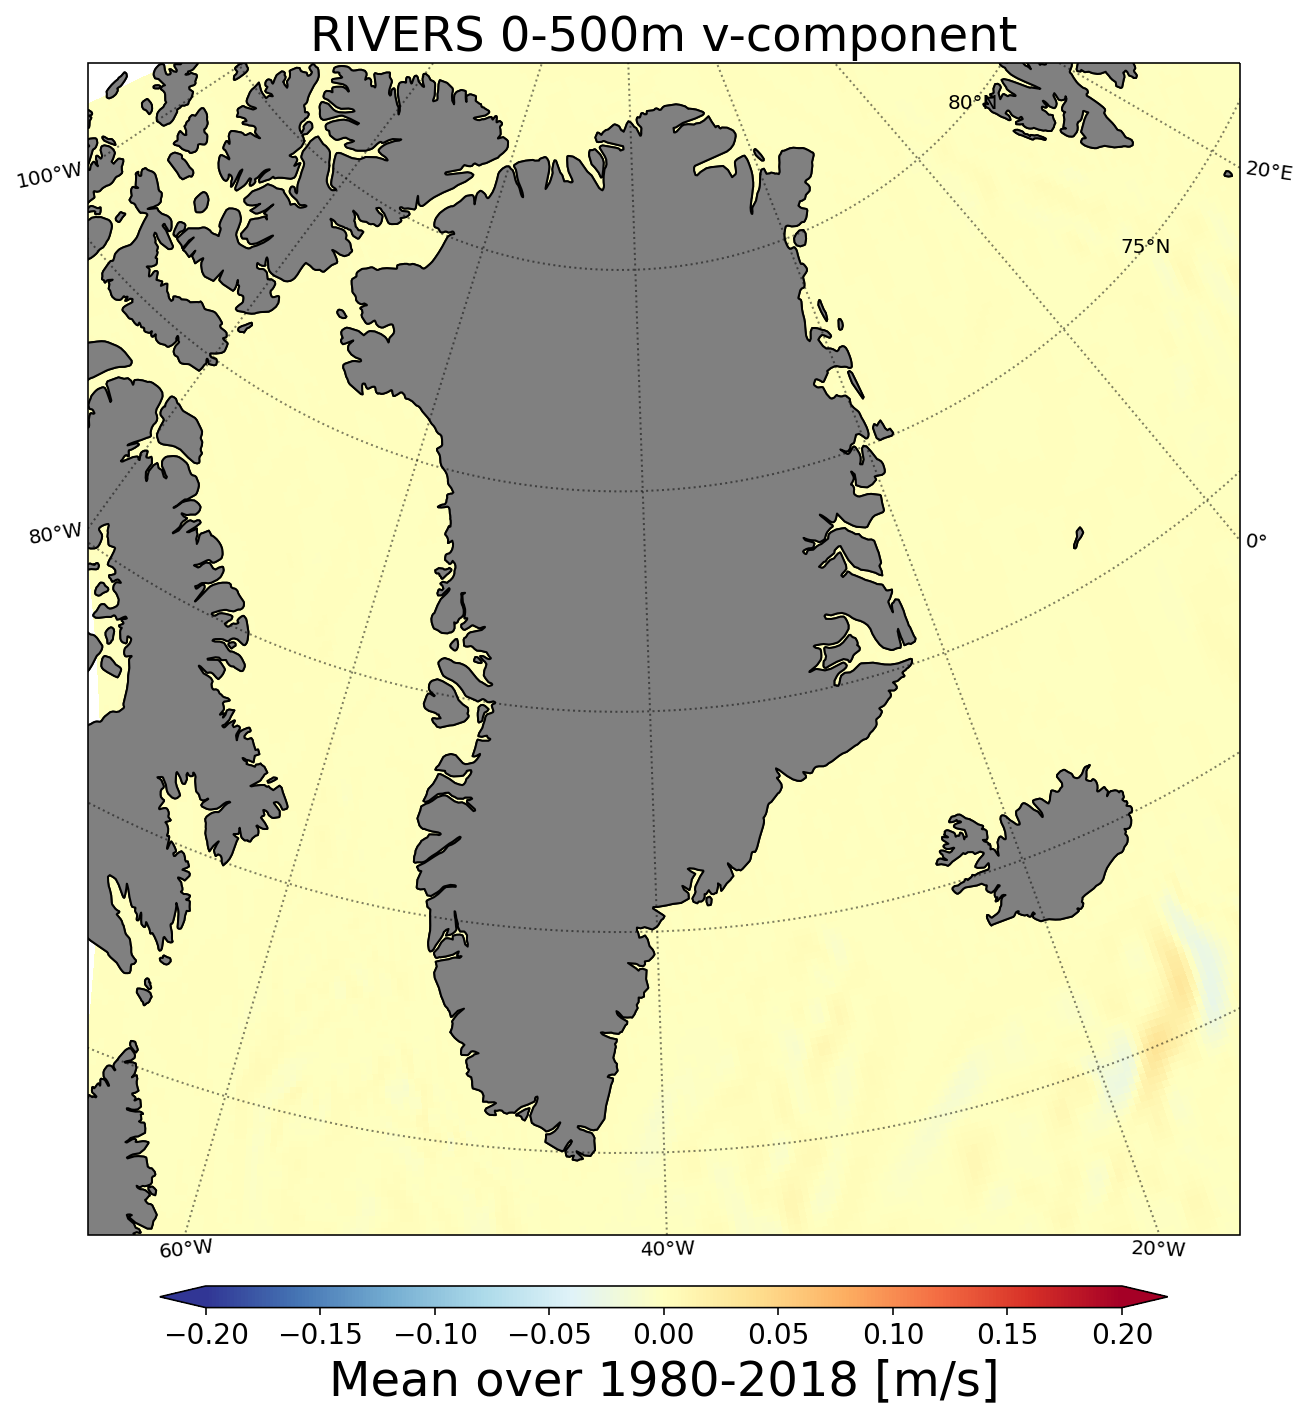

In [13]:
# proj1 = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=70, central_longitude=-42) 
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
# label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

fig, ax_name = plt.subplots(1,1,figsize=(10,15),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
ax_name.set_extent((-65, -15, 58, 84), crs=ccrs.PlateCarree())
ax_name.coastlines()
gl = ax_name.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)#, y_inline=True,)
gl.top_labels = False
# gl.xlabel_style = label_style; gl.ylabel_style = label_style
ax_name.add_feature(land, edgecolor='black')

# --------------------------------------
cs= ax_name.pcolormesh(nav_lon, nav_lat, V_vit_wtmean_tm_AI_S, shading='flat',cmap =cm.RdYlBu_r, transform=ccrs.PlateCarree(), vmin =-0.2, vmax=0.2)
# ---------------------------------------

cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.01])  #(left, bottom, width, height)

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)

# fig.subplots_adjust(bottom=0.18)

# ---------------------------------------
cbar.set_label(r'Mean over 1980-2018 [m/s]', fontsize=24)
# cbar.set_label(r'Mean over 1993-2015 [m/s]', fontsize=24)
# ---------------------------------------


ax_name.set_title("RIVERS 0-500m v-component", fontsize=24) 

# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 

namo ='AI_S_0_500m_mean1980-2018_v.png'
# namo ='GAI_0_500m_mean1993-2015_v.png'


fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


### en changeant la colorbar 

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


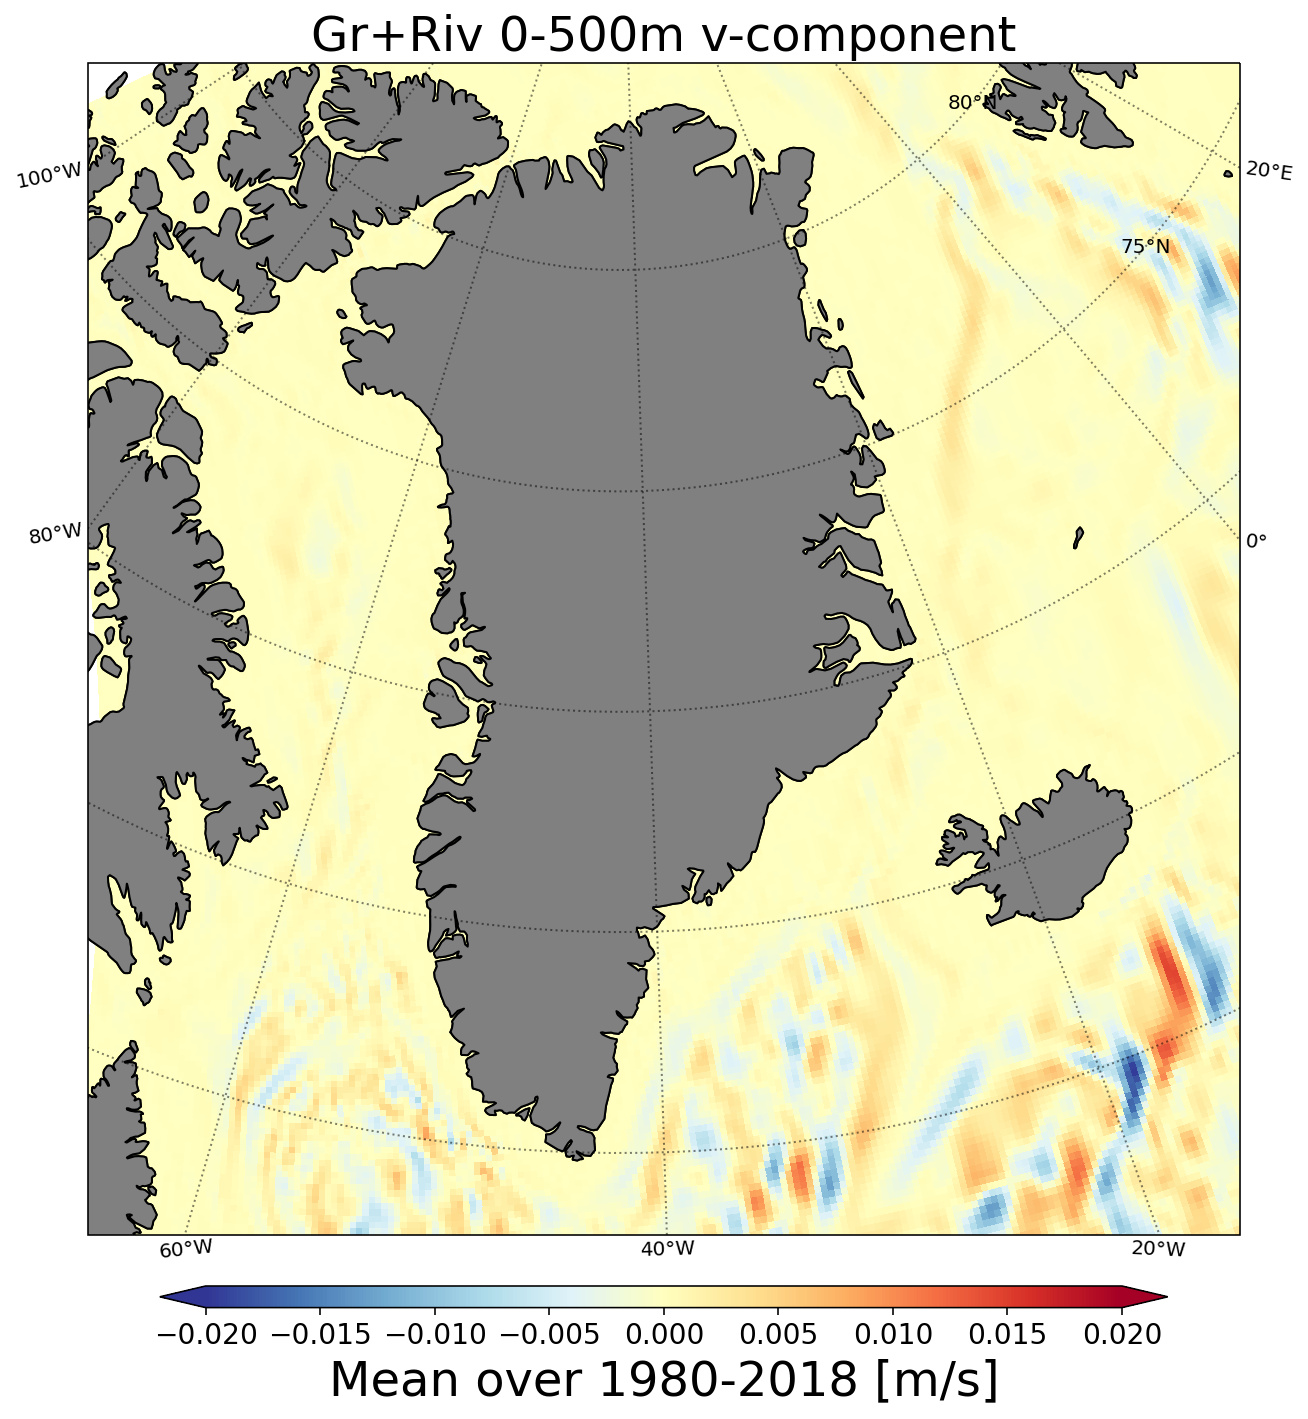

In [14]:
# proj1 = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=70, central_longitude=-42) 
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
# label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

fig, ax_name = plt.subplots(1,1,figsize=(10,15),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
ax_name.set_extent((-65, -15, 58, 84), crs=ccrs.PlateCarree())
ax_name.coastlines()
gl = ax_name.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)#, y_inline=True,)
gl.top_labels = False
# gl.xlabel_style = label_style; gl.ylabel_style = label_style
ax_name.add_feature(land, edgecolor='black')

# --------------------------------------
cs= ax_name.pcolormesh(nav_lon, nav_lat, V_vit_wtmean_tm_GAI_S, shading='flat',cmap =cm.RdYlBu_r, transform=ccrs.PlateCarree(), vmin =-0.02, vmax=0.02)
# ---------------------------------------

cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.01])  #(left, bottom, width, height)

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)

# fig.subplots_adjust(bottom=0.18)

# ---------------------------------------
cbar.set_label(r'Mean over 1980-2018 [m/s]', fontsize=24)
# cbar.set_label(r'Mean over 1993-2015 [m/s]', fontsize=24)
# ---------------------------------------


ax_name.set_title("Gr+Riv 0-500m v-component", fontsize=24) 

# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 

namo ='GAI_S_0_500m_mean1980-2018_v_v2.png'
# namo ='GAI_0_500m_mean1993-2015_v.png'


fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


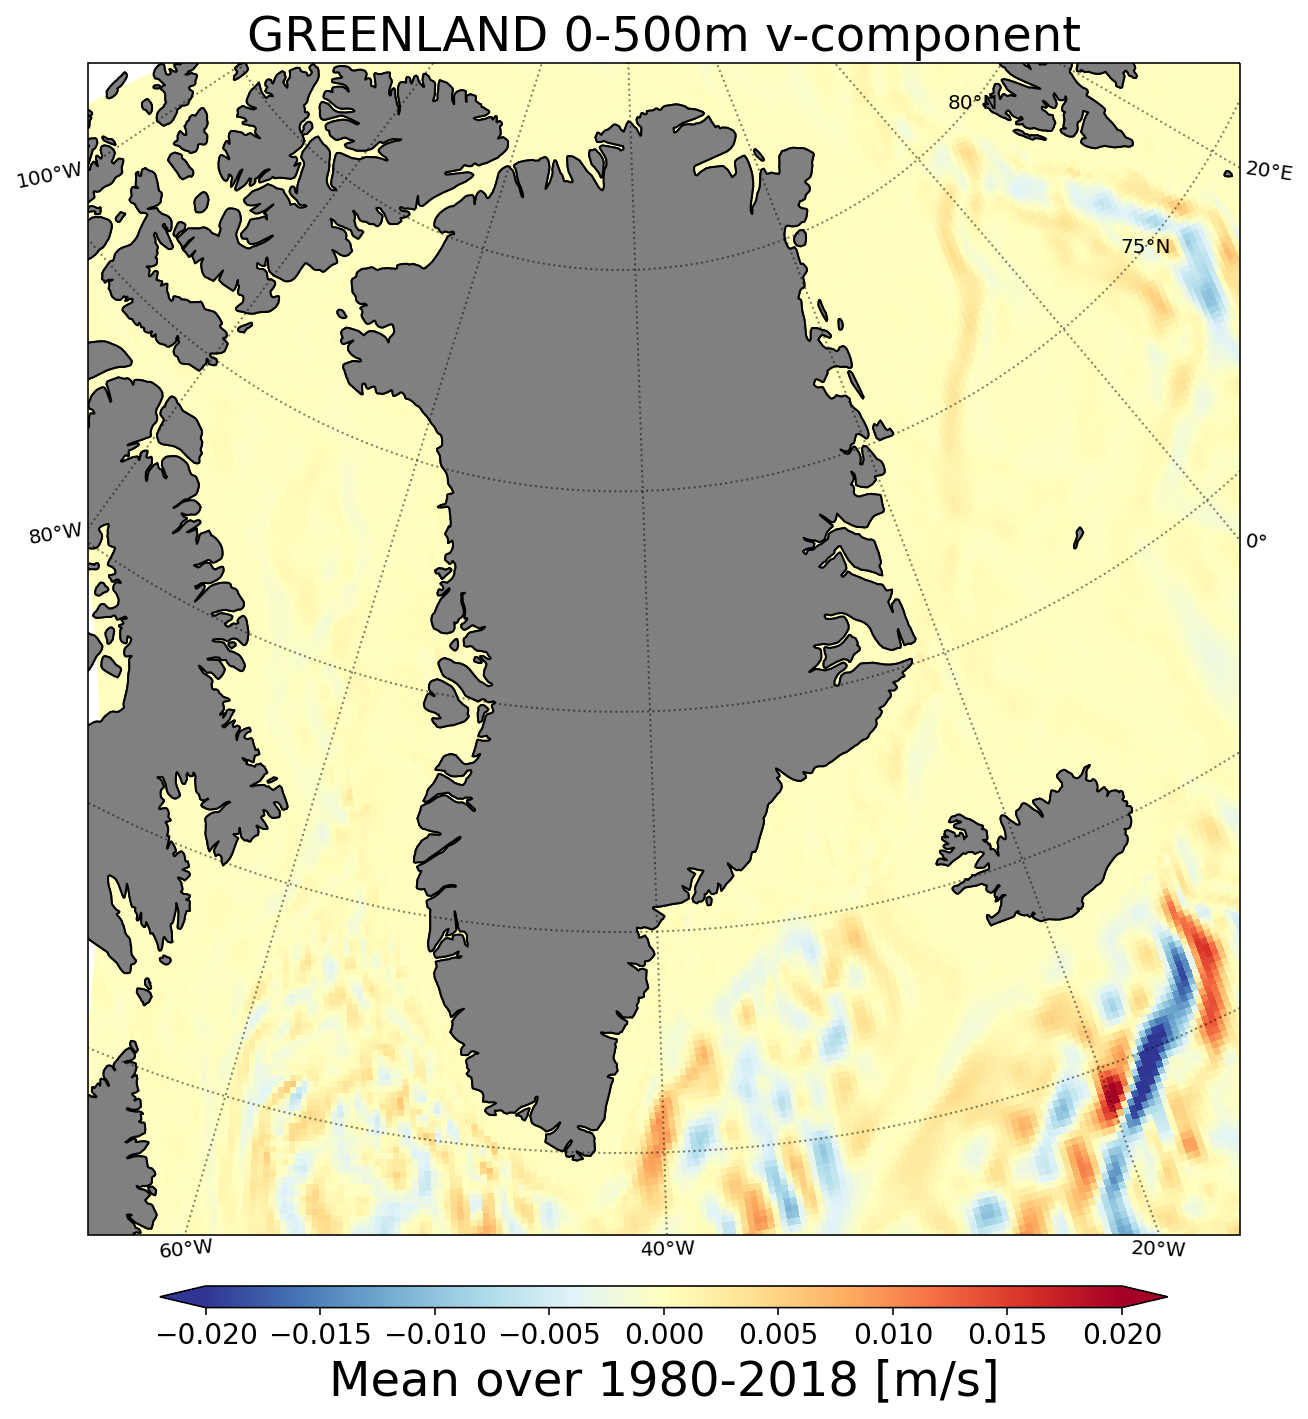

In [15]:
# proj1 = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=70, central_longitude=-42) 
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
# label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

fig, ax_name = plt.subplots(1,1,figsize=(10,15),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
ax_name.set_extent((-65, -15, 58, 84), crs=ccrs.PlateCarree())
ax_name.coastlines()
gl = ax_name.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)#, y_inline=True,)
gl.top_labels = False
# gl.xlabel_style = label_style; gl.ylabel_style = label_style
ax_name.add_feature(land, edgecolor='black')

# --------------------------------------
cs= ax_name.pcolormesh(nav_lon, nav_lat, V_vit_wtmean_tm_GAI_AI, shading='flat',cmap =cm.RdYlBu_r, transform=ccrs.PlateCarree(), vmin =-0.02, vmax=0.02)
# ---------------------------------------

cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.01])  #(left, bottom, width, height)

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)

# fig.subplots_adjust(bottom=0.18)

# ---------------------------------------
cbar.set_label(r'Mean over 1980-2018 [m/s]', fontsize=24)
# cbar.set_label(r'Mean over 1993-2015 [m/s]', fontsize=24)
# ---------------------------------------


ax_name.set_title("GREENLAND 0-500m v-component", fontsize=24) 

# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 

namo ='GAI_AI_0_500m_mean1980-2018_v_v2.png'
# namo ='GAI_0_500m_mean1993-2015_v.png'


fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


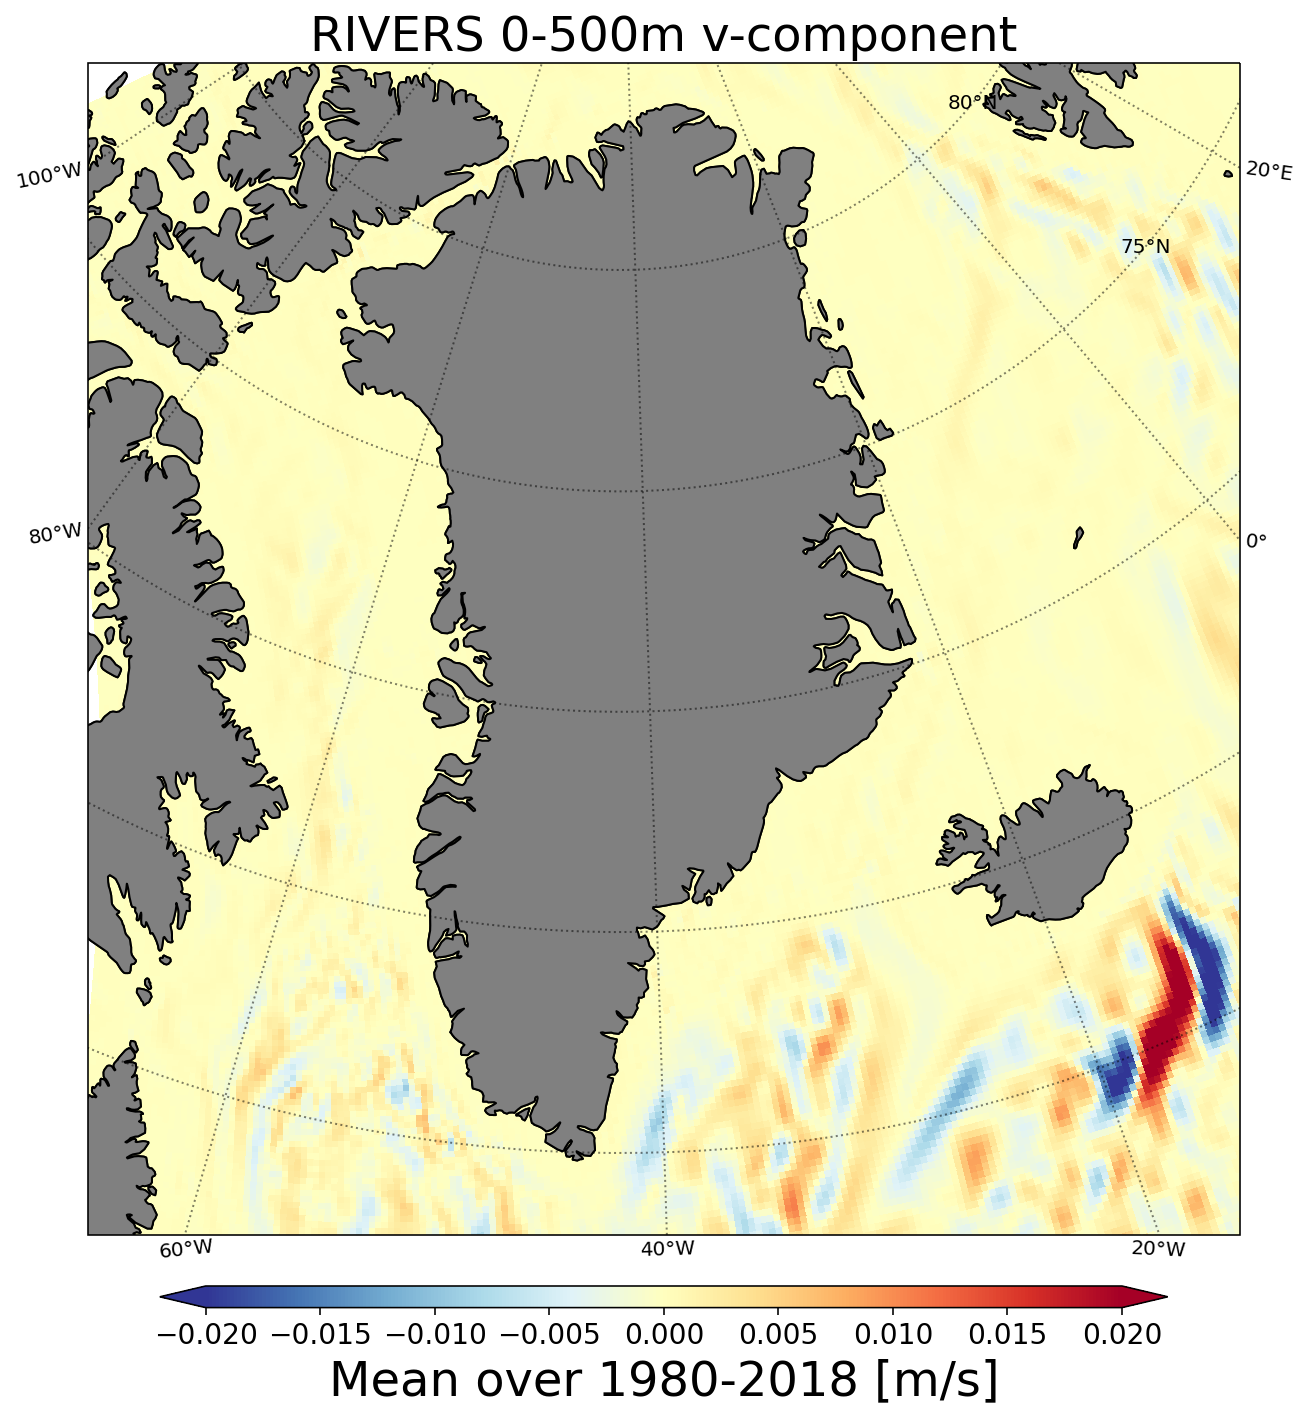

In [16]:
# proj1 = ccrs.PlateCarree()
proj = ccrs.Stereographic(central_latitude=70, central_longitude=-42) 
land  = cfeature.NaturalEarthFeature(name='land',scale='50m', category='physical',facecolor='grey')
# label_style = {'size': 8, 'color': '#BDBDBD', 'weight': 'normal'}

fig, ax_name = plt.subplots(1,1,figsize=(10,15),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
ax_name.set_extent((-65, -15, 58, 84), crs=ccrs.PlateCarree())
ax_name.coastlines()
gl = ax_name.gridlines(color='k',alpha=0.5, linestyle='--',linewidth=0.33,lw=1,ls=':', draw_labels=True)#, y_inline=True,)
gl.top_labels = False
# gl.xlabel_style = label_style; gl.ylabel_style = label_style
ax_name.add_feature(land, edgecolor='black')

# --------------------------------------
cs= ax_name.pcolormesh(nav_lon, nav_lat, V_vit_wtmean_tm_AI_S, shading='flat',cmap =cm.RdYlBu_r, transform=ccrs.PlateCarree(), vmin =-0.02, vmax=0.02)
# ---------------------------------------

cbar_ax = fig.add_axes([0.15, 0.22, 0.7, 0.01])  #(left, bottom, width, height)

cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=14)

# fig.subplots_adjust(bottom=0.18)

# ---------------------------------------
cbar.set_label(r'Mean over 1980-2018 [m/s]', fontsize=24)
# cbar.set_label(r'Mean over 1993-2015 [m/s]', fontsize=24)
# ---------------------------------------


ax_name.set_title("RIVERS 0-500m v-component", fontsize=24) 

# fig.tight_layout(pad=0, h_pad=5, w_pad=0) 

namo ='AI_S_0_500m_mean1980-2018_v_v2.png'
# namo ='GAI_0_500m_mean1993-2015_v.png'


fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 
